In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import time
import timeit
import math

import itertools
import collections
from collections import OrderedDict

from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook

import numpy as np
import pandas as pd
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

from draw import show_img, show_img_grid
from boundingbox import CoordinateType, FormatType, BoundingBoxConverter
from transforms import IaaAugmentations, IaaLetterbox, ToTensor, Compose, \
                       iaa_hsv_aug, iaa_random_crop, iaa_letterbox
from dataset import worker_init_fn, variable_shape_collate_fn

# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [2]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [3]:
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

In [4]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [5]:
classes = load_coco(coco_path)

In [6]:
cv2.setNumThreads(0)

# Draw

In [7]:
from matplotlib import patches, patheffects

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_grid(ax, grid_interval):
    loc = plticker.MultipleLocator(base=grid_interval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_axis(ax, isDraw=False):
    ax.get_xaxis().set_visible(isDraw)
    ax.get_yaxis().set_visible(isDraw)

def draw_image(ax, img):
    ax.imshow(img, shape=(2,2), aspect='equal')

def draw_labels(ax, labels, classes, coord_idx=[1,2,3,4], class_idx=0):
    for l in labels:
        if l.sum() == 0:
            continue
        rect = l[coord_idx]
        c = classes[l[class_idx].astype(np.int32)]
        draw_rect(ax, rect)
        draw_text(ax, rect[:2], c)
        
# Display a list of images with labels in given grid size         
def show_img_grid(img_list, classes=None,
                  labels_list=None, coord_idx=[1,2,3,4], class_idx=0,
                  cols=2, figsize=None):
    rows = int(np.ceil(len(img_list) / cols))
    if figsize is None:
        figsize = (20, 20*rows / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axes = [ax for ax in axes.ravel()]
    
    for ax, img, labels in itertools.zip_longest(axes, img_list, labels_list, fillvalue=None):
        if img is not None:
            draw_image(ax, img)
        if labels is not None:
            draw_labels(ax, labels, classes, coord_idx=coord_idx, class_idx=class_idx)
        draw_axis(ax, False)
   
    plt.tight_layout()

# Bounding Boxes Coordinates Transforms

In [8]:
def bbox_x1y1x2y2_to_xywh(box):
    bx, by = box[..., 0], box[..., 1]
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = bx, by, bw, bh
    return box

def bbox_x1y1x2y2_to_cxcywh(box):
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    cx, cy = box[..., 0] + bw / 2, box[..., 1] + bh / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = cx, cy, bw, bh
    return box

def bbox_cxcywh_to_x1y1x2y2(box):
    x1, x2 = box[..., 0] - box[..., 2] / 2, box[..., 0] + box[..., 2] / 2
    y1, y2 = box[..., 1] - box[..., 3] / 2, box[..., 1] + box[..., 3] / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = x1, y1, x2, y2
    return box

def bbox_cxcywh_to_xywh(box):
    x, y = box[..., 0] - box[..., 2] / 2, box[..., 1] - box[..., 3] / 2
    box[..., 0], box[..., 1] = x, y
    return box

# Modify  to accomodate varying-length tensors (original image size)

In [9]:
from torch._six import string_classes, int_classes
# Modify 'default_collate' from dataloader.py in pytorch library
# Read 'default_collate' from https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataloader.py
# Only a small portion is modified

def variable_shape_collate_fn(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""
    _use_shared_memory = True

    error_msg = "batch must contain tensors, numbers, dicts or lists; found {}"
    elem_type = type(batch[0])
    if isinstance(batch[0], torch.Tensor):
        # Check if the tensors have same shapes.
        # If True, stack the tensors. If false, return a list of tensors
        is_same_shape = all([b.shape == batch[0].shape for b in batch])
        if not is_same_shape:
            return batch
        else:
            out = None
            if _use_shared_memory:
                # If we're in a background process, concatenate directly into a
                # shared memory tensor to avoid an extra copy
                numel = sum([x.numel() for x in batch])
                storage = batch[0].storage()._new_shared(numel)
                out = batch[0].new(storage)
            return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if re.search('[SaUO]', elem.dtype.str) is not None:
                raise TypeError(error_msg.format(elem.dtype))

            return torch.stack([torch.from_numpy(b) for b in batch], 0)
        if elem.shape == ():  # scalars
            py_type = float if elem.dtype.name.startswith('float') else int
            return numpy_type_map[elem.dtype.name](list(map(py_type, batch)))
    elif isinstance(batch[0], int_classes):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], string_classes):
        return batch
    elif isinstance(batch[0], collections.Mapping):
        return {key: variable_shape_collate_fn([d[key] for d in batch]) for key in batch[0]}
    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [variable_shape_collate_fn(samples) for samples in transposed]
    elif callable(batch[0]):
        return batch

    raise TypeError((error_msg.format(type(batch[0]))))

# Use worker_init_fn to reinitialize seed across multiprocessing workers (ensure deterministic behaviour)

In [10]:
def worker_init_fn(worker_id):
    base_seed = int(torch.randint(2**32, (1,)).item())
    lib_seed = (base_seed + worker_id) % (2**32)
    ia.seed(lib_seed)
    np.random.seed(lib_seed)

# Dataset

In [11]:
class COCODataset(Dataset):
    def __init__(self, targ_txt, dim=None, bbs_idx=np.arange(0,4), transform=None):
        with open(targ_txt, 'r') as f:
            self.img_list = [lines.strip() for lines in f.readlines()]
        self.label_list = [img_path.replace('jpg', 'txt').replace('images', 'labels') for img_path in self.img_list]
        self.dim = dim
        self.bbs_idx = bbs_idx
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        label = None
        img_path = self.img_list[idx]
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)
        
        label_path = self.label_list[idx]
        if osp.exists(label_path):
            label = np.loadtxt(label_path).reshape(-1,5)
            
        sample = { 'img': img, 'org_img': img.copy(), 'label': label, 'transform': None, 'img_path': img_path }
        sample = self.transform(sample)
        
        return sample

# Transforms and Augmentations

In [12]:
def getTransforms(dim, aug=True):
    if aug:
        transform = Compose([IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5),
                                               iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    else:
        transform = Compose([IaaAugmentations([IaaLetterbox(dim)
                                              ]),
                             ToTensor()])
    return transform

In [13]:
def get_trans_fn(aug):
    def getTransformByDim(dim):
        return getTransforms(dim, aug=aug)
    return getTransformByDim

# Test dataset

In [14]:
def test_dataset(dataset, dim, bs, classes_names, shuffle=True, subset_idx=None, isShowImg=True):
    if subset_idx is not None:
        dataset = Subset(dataset, subset_idx)
        
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle,
                      worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn, num_workers=2)

    processed_batch = 0
    img_list = []
    labels_list = torch.FloatTensor()
    for i in range(0,2):
        for sample in dataloader:
            img_list += [img for img in sample['img'].permute(0,2,3,1).numpy()]         
            dim = (sample['img'].shape[3], sample['img'].shape[2])

            labels_list = torch.cat((labels_list, sample['label']), 0)
            labels_list = labels_list.numpy()
            labels_list = BoundingBoxConverter.convert(labels_list, CoordinateType.Relative, FormatType.cxcywh,
                                                              CoordinateType.Absolute, FormatType.xywh,
                                                              np.array([1,2,3,4]), dim)
            #print(img_list.shape)
            if isShowImg:
                show_img_grid(img_list, cols=4, classes=classes_names, labels_list=labels_list)

            img_list = []
            labels_list = torch.FloatTensor()
            processed_batch += 1


In [15]:
sz = 416
bs = 8
dim = (sz, sz)

dataset_subset_idx = np.arange(0, 8)

train_transform = getTransforms(dim, True)
train_ds = COCODataset(train_target_txt, bbs_idx=np.arange(1,5), transform=train_transform)

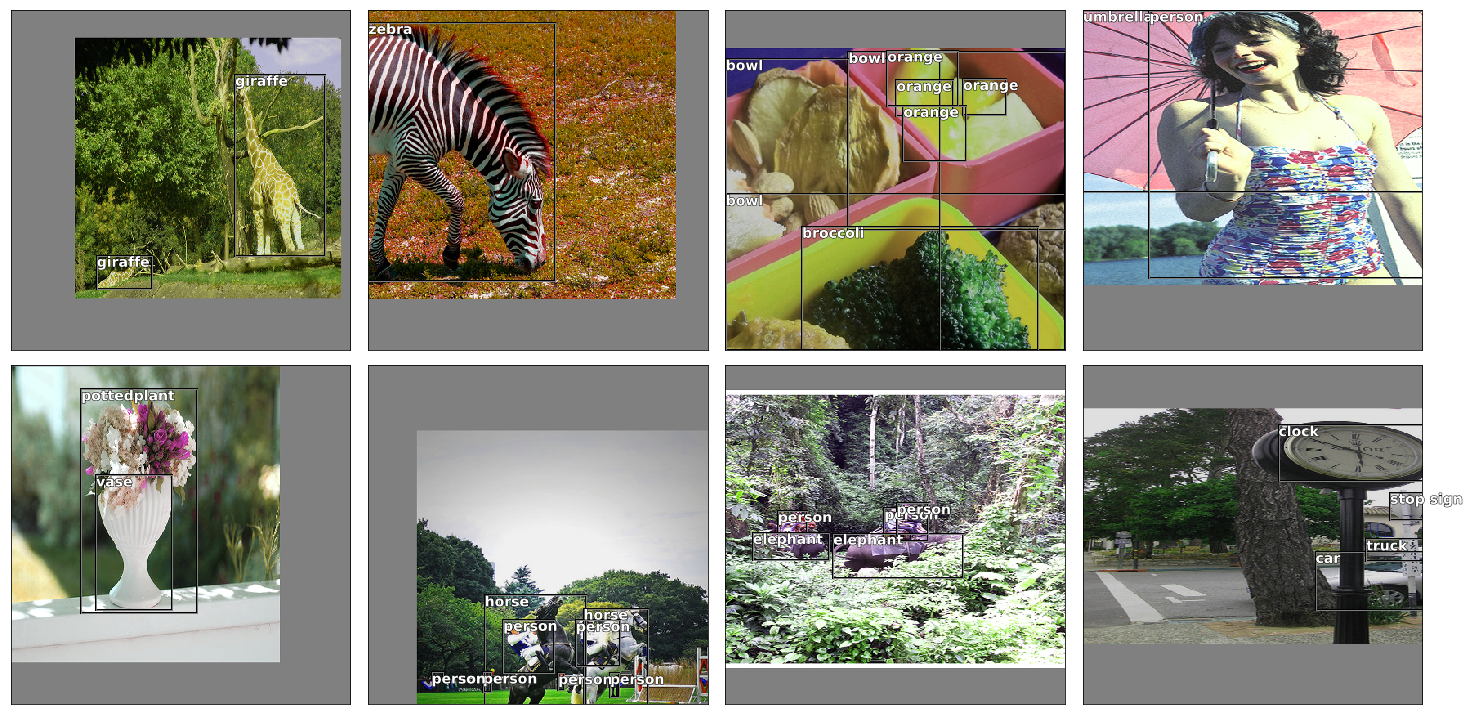

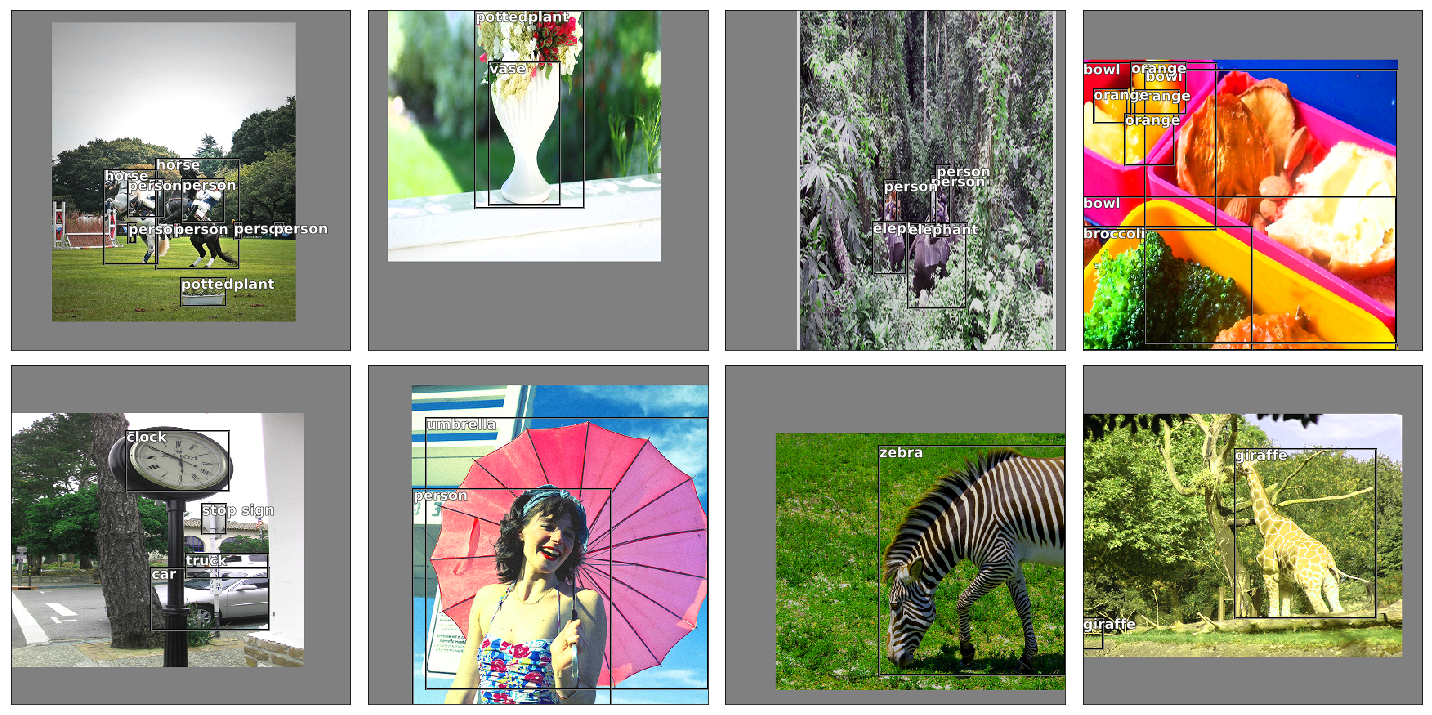

In [16]:
torch.manual_seed(8)
np.random.seed(8)
test_dataset(train_ds, dim, bs, classes, subset_idx=dataset_subset_idx)

# Making it resumeable between batches and determinsitic (Refer to Deterministic_data_loading.ipynb for more details)

In [17]:
from dataset import RandomCyclicDataset, DataHelper

In [18]:
class COCODataset(RandomCyclicDataset):
    
    def __init__(self, targ_txt_path, batch_size, shuffle=True, cyclic=True, dim=None, rand_dim_interval=None,
                 trans_fn=None, subset_idx=None):
        self.trans_fn = trans_fn
        self.subset_idx = subset_idx
        self.img_list, self.label_list = self._get_images_and_labels(targ_txt_path)
        super().__init__(batch_size, shuffle, cyclic, dim, rand_dim_interval)
        
    def get_base_indices(self):
        length = len(self.img_list)
        base_indices = torch.arange(0, length, dtype=torch.int64)
        if self.subset_idx is not None:
            base_indices = base_indices[self.subset_idx]
        return base_indices.tolist()
    
    def _get_images_and_labels(self, targ_txt_path):
        with open(targ_txt_path, 'r') as f:
            img_list = [lines.strip() for lines in f.readlines()]
        label_list = [img_path.replace('jpg', 'txt').replace('images', 'labels') for img_path in img_list]
        return img_list, label_list
    
    def __getitem__(self, idx):
        label = None
        
        seed = self.rands[idx]
        ia.seed(seed)
        np.random.seed(seed)
        
        dim = self.dims[idx]
        transform = self.trans_fn(dim)
        
        sel_idx = self.base_indices[self.indices[idx]]
        img_path = self.img_list[sel_idx]
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)
        
        label_path = self.label_list[sel_idx]
        if osp.exists(label_path):
            label = np.loadtxt(label_path).reshape(-1,5)
        
        sample = { 'img': img, 'org_img': img.copy(), 'label': label, 'transform': None, 'img_path': img_path }
        sample = transform(sample)
        return sample

## Testing functions

In [19]:
def save_data_state(data, checkpoint_path):
    checkpoint = {'data' : data.get_state_dict()}
    torch.save(checkpoint, checkpoint_path)
    
def load_data_state(data, checkpoint_path):
    checkpoint = torch.load(checkpoint_path,  map_location=lambda storage, loc: storage)
    data.load_state_dict(checkpoint['data'])
    return data  

def run_data_batches(data, classes_names, isShowImg=True, save=True,
                     load_checkpoint_path=None, save_checkpoint_path=None,
                     debug_batch_cut_off=None):
    processed_batch = 0
    state_dict_list = []
    img_list = []
    labels_list = torch.FloatTensor()
    
    if load_checkpoint_path is not None:
        load_data_state(data, load_checkpoint_path)
        
    for sample in data:
        dim = (sample['img'].shape[3], sample['img'].shape[2])
        img_list += [img for img in sample['img'].permute(0,2,3,1).numpy()]         
        
        labels_list = torch.cat((labels_list, sample['label']), 0)
        labels_list = labels_list.numpy()
        labels_list = BoundingBoxConverter.convert(labels_list, CoordinateType.Relative, FormatType.cxcywh,
                                                          CoordinateType.Absolute, FormatType.xywh,
                                                          np.array([1,2,3,4]), dim)
        if isShowImg:
            show_img_grid(img_list, cols=4, classes=classes_names, labels_list=labels_list)

        img_list = []
        labels_list = torch.FloatTensor()

        print('Batch:{} {}'.format(data.current_batch, str(sample['img'].shape)))
        if save_checkpoint_path is not None:
            save_data_state(data, save_checkpoint_path)

        processed_batch += 1
        
        if debug_batch_cut_off is not None and processed_batch >= debug_batch_cut_off:
            break

## DataHelper - provides an iterator that output batches that goes through the dataset in cyclic way

In [20]:
def getCOCOData(seed, train_target_txt, bs, max_batches=0, dim=None, rand_dim_interval=None, subset_idx=None, shuffle=False):
    torch.manual_seed(seed)
    trans_fn = get_trans_fn(True)
    coco_ds = COCODataset(train_target_txt, bs, subset_idx=subset_idx, trans_fn=trans_fn, shuffle=shuffle, dim=dim, rand_dim_interval=rand_dim_interval)
    coco_dl = DataLoader(coco_ds, batch_size=bs, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn)
    coco_data = DataHelper(coco_ds, coco_dl, current_batch=0, max_batches=max_batches)
    return coco_data

## Test

In [21]:
bs = 4
sz = 416
dim = (sz, sz)
shuffle = True
train_target_txt = "./data/coco/trainvalno5k.txt"

seed = 0
# Change dimension every 2 batches
random_dim_interval = bs * 2
subset_idx = np.arange(0, 9)

Batch:0 torch.Size([4, 3, 544, 544])
Batch:1 torch.Size([4, 3, 544, 544])
Batch:2 torch.Size([4, 3, 416, 416])
Batch:3 torch.Size([4, 3, 416, 416])


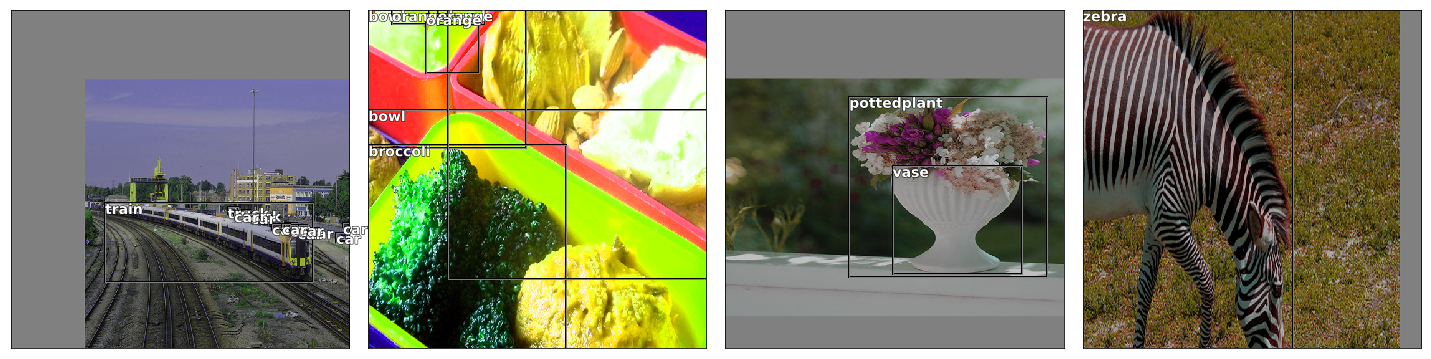

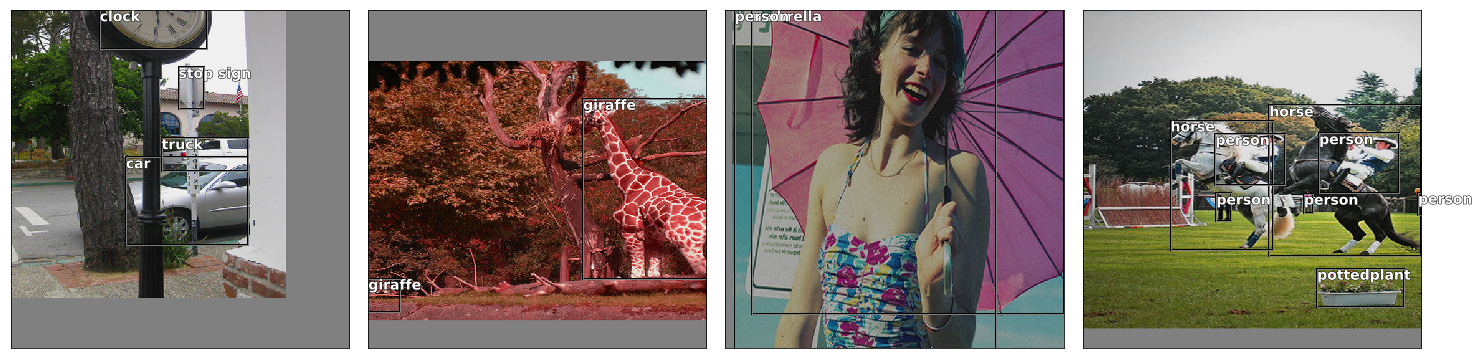

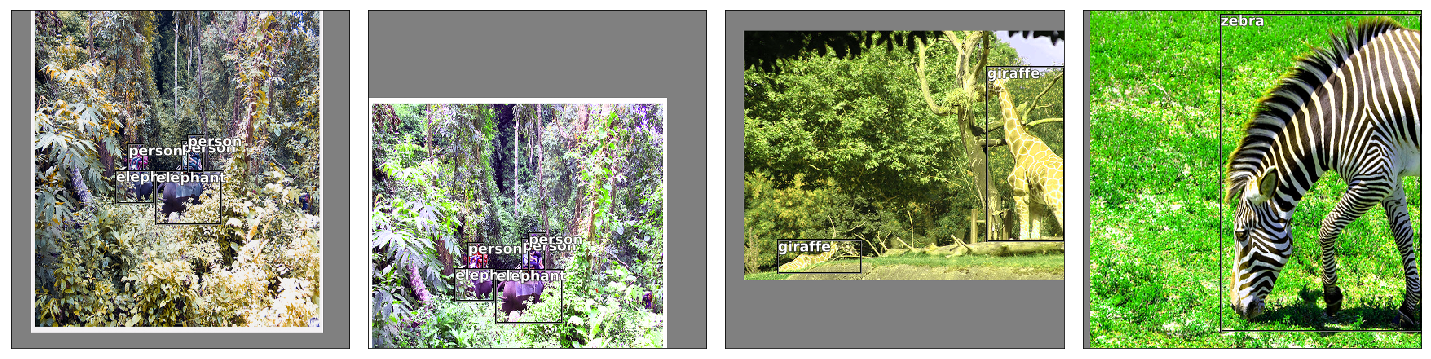

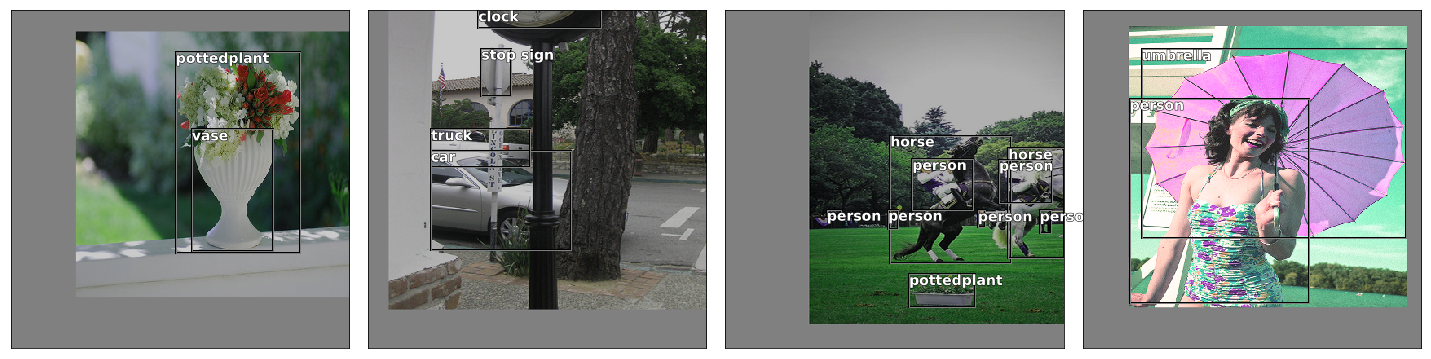

In [22]:
coco_data = getCOCOData(seed, train_target_txt, bs, max_batches=4, subset_idx=subset_idx,
                        dim=None, rand_dim_interval=random_dim_interval, shuffle=True)
run_data_batches(coco_data, classes, isShowImg=True, save=True,
                 load_checkpoint_path=None, save_checkpoint_path=None,
                 debug_batch_cut_off=None)